# Split into 500 and 330 group, find features on 500 and test on 330

models: Linear, LASSO, MLP, LatSim + Correlation Top 10 both 5 positive + 5 negative
task: rest, nback, emoid
preproc: FC, PC

In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/test'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['age'].keys()))
print(len(subs))

830


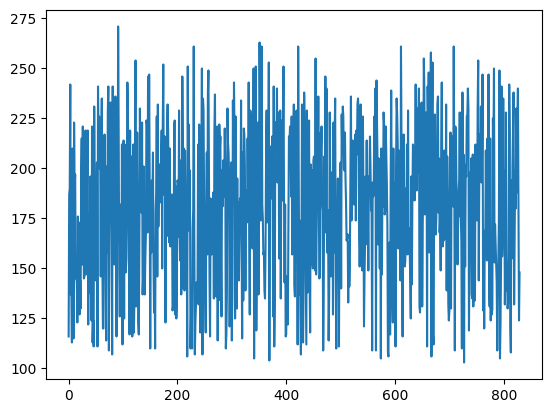

In [2]:
import matplotlib.pyplot as plt

plt.plot([demo['age'][sub] for sub in subs])
plt.show()

In [260]:
import numpy as np
from sklearn.decomposition import PCA

task = 'restdd'
pre = 'partial'

# Load FC 

fcs = []
ages = []

for sub in subs:
#     fname = f'{basedir}/{pre}/{sub}_task-{task}_{pre}.npy'
    fname = f'{basedir}/decomp/{task}-weights/{sub}_comp-{task}_weights.npy'
    fc = np.load(fname)
    fcs.append(fc)
    ages.append(demo['age'][sub])
    
fcs = np.stack(fcs)[:,:100]

# pca = PCA().fit(fcs[:500])
# fcs = pca.transform(fcs)
    
ages = np.array(ages)
print(fcs.shape)
print(ages.shape)
print(ages[0:3])

(830, 100)
(830,)
[116 187 190]


In [224]:
# Correlation

x = fcs[:500]
mux = np.mean(x, axis=0, keepdims=True)
x = x - mux
y = ages[:500]
muy = np.mean(y)
y = y - muy
xx = np.einsum('ab,ab->b',x,x)
yy = np.einsum('a,a->',y,y)
xy = np.einsum('ab,a->b',x,y)
rho = xy / (xx*yy)**0.5

idcs = np.argsort(rho)
bot_idcs = idcs[0:5]
top_idcs = idcs[-5:]
print('Done')
print(rho[bot_idcs])
print(rho[top_idcs])

Done
[-0.37037269 -0.19846373 -0.18746254 -0.16809365 -0.16326615]
[0.1197734  0.12038079 0.12136209 0.1270498  0.12871319]


In [236]:
# Test correlation

from sklearn.linear_model import Ridge

sav_idcs = np.concatenate([bot_idcs, top_idcs])
print(sav_idcs)

ntrain = 500

xtr = fcs[:ntrain]#[:,sav_idcs]
xt = fcs[ntrain:]#[:,sav_idcs]

ytr = ages[:ntrain]
yt = ages[ntrain:]

muy = np.mean(ytr)
ytr = ytr - muy
yt = yt - muy

reg = Ridge(alpha=0,fit_intercept=False).fit(xtr, ytr)
yhat = reg.predict(xt)

print(np.mean((yhat-yt)**2)**0.5)

[  1   4  17   8  16 116  38 199 547 123]
28.20680447821024


In [232]:
# Linear

from sklearn.linear_model import Lasso

ntrain = 500
nn = 400
rs = []
coef = []

for i in range(20):
    idcs = np.random.permutation(ntrain)
    x = fcs[:ntrain]
    x = x[idcs]
    xtr = x[:nn]
    xt = x[nn:]

    y = ages[:ntrain]
    y = y[idcs]
    ytr = y[:nn]
    yt = y[nn:]
    
    muy = np.mean(ytr)
    ytr = ytr - muy
    yt = yt - muy

    reg = Lasso(alpha=1,max_iter=10000,fit_intercept=False).fit(xtr, ytr)
#     reg = Ridge(alpha=0,fit_intercept=False).fit(xtr, ytr)
    yhat = reg.predict(xt)
    rmse = np.mean((yhat-yt)**2)**0.5
    rmse = float(rmse)
    print(rmse)
    rs.append(rmse)
    coef.append(reg.coef_*np.mean(xtr, axis=0))
    
print('---')
print(np.mean(rs))
print(np.std(rs))
# idcs = np.argsort(np.abs(reg.coef_))[-10:]
# print(idcs)
# reg.coef_[idcs]

32.98866737897667
36.33135235438699
34.25175135531742
33.22160246863516
31.14462536690216
33.77482979788987
37.55041154322705
32.438510164954714
31.855315514496898
33.1921861497273
31.623522500444917
32.32014595294846
36.1502396334922
34.422771699330625
33.539516569342936
32.756681324951316
33.913762368506724
33.06008980835504
29.68081988484494
31.472763406585905
---
33.28447826216587
1.821406633476812


In [233]:
cc = np.stack(coef)
cc = np.mean(cc, axis=0)
# idcs = np.argsort(cc)
idcs = np.argsort(np.abs(cc))[-10:]
# idcs = np.concatenate([idcs[:5], idcs[-5:]])
print(idcs)
print(cc[idcs])

[143  16  17 123  12  37   4  30 199   1]
[-0.10733859 -0.11944599 -0.11988855  0.12131558 -0.16618999 -0.16881729
  0.1724586   0.17933805 -0.18174352 -0.51392924]


In [234]:
# Test linear

ntrain = 500

xtr = fcs[:ntrain][:,idcs]
xt = fcs[ntrain:][:,idcs]

ytr = ages[:ntrain]
yt = ages[ntrain:]

muy = np.mean(ytr)
ytr = ytr - muy
yt = yt - muy

reg = Ridge(alpha=0,fit_intercept=False).fit(xtr, ytr)
yhat = reg.predict(xt)
rmse = np.mean((yhat-yt)**2)**0.5
rmse = float(rmse)
print(rmse)

33.389901425987915


In [49]:
reg.coef_

array([ -941.7474 ,  1712.5957 ,  -781.12225, -5703.0757 , -3244.1824 ,
        1817.9519 ,   292.3251 ,   531.49133,  1156.4578 ,  2956.4695 ],
      dtype=float32)

In [264]:
from sklearn.linear_model import Ridge, LinearRegression

# Greedy selection

rs = []
for j in range(10):
    ridcs = np.random.permutation(830)
    x = fcs[ridcs][:500]
    mux = np.mean(x, axis=0, keepdims=True)
    x = x - mux

    r = ages[ridcs][:500]
    sel_idcs = []

    for i in range(10):
        mur = np.mean(r)
        r = r - mur
        xx = np.einsum('ab,ab->b',x,x)
        rr = np.einsum('a,a->',r,r)
        xr = np.einsum('ab,a->b',x,r)
        rho = xr / (xx*rr)**0.5

        idcs = np.argsort(np.abs(rho))[::-1]
        for j in range(10):
            if idcs[j] not in sel_idcs:
                sel_idcs.append(idcs[j])
                break

        print(sel_idcs)
        xtr = fcs[ridcs][:500][:,sel_idcs]
        xt = fcs[ridcs][500:][:,sel_idcs]

    #     mux = np.mean(xtr, axis=0, keepdims=True)
    #     xtr = xtr - mux
    #     xt = xt - mux

        ytr = ages[ridcs][:500]
        yt = ages[ridcs][500:]

        muy = np.mean(ytr)
        ytr = ytr - muy
        yt = yt - muy

        reg = Ridge(alpha=0.001,fit_intercept=False).fit(xtr, ytr)
        yhat = reg.predict(xt)
        rmse = np.mean((yhat-yt)**2)**0.5
        rmse = float(rmse)
#         print(rmse)

        yhat = reg.predict(xtr)
#         rmse = np.mean((yhat-ytr)**2)**0.5
#         rmse = float(rmse)
#         print(rmse)
        r = ytr-yhat
    
    rs.append(rmse)
    print(rs[-1])
    
print(np.mean(rs))

[22]
[22, 28]
[22, 28, 96]
[22, 28, 96, 98]
[22, 28, 96, 98, 70]
[22, 28, 96, 98, 70, 7]
[22, 28, 96, 98, 70, 7, 62]
[22, 28, 96, 98, 70, 7, 62, 27]
[22, 28, 96, 98, 70, 7, 62, 27, 92]
[22, 28, 96, 98, 70, 7, 62, 27, 92, 63]
36.078261131301296
[28]
[28, 0]
[28, 0, 2]
[28, 0, 2, 22]
[28, 0, 2, 22, 1]
[28, 0, 2, 22, 1, 71]
[28, 0, 2, 22, 1, 71, 89]
[28, 0, 2, 22, 1, 71, 89, 96]
[28, 0, 2, 22, 1, 71, 89, 96, 81]
[28, 0, 2, 22, 1, 71, 89, 96, 81, 58]
35.92295235436102
[28]
[28, 0]
[28, 0, 42]
[28, 0, 42, 22]
[28, 0, 42, 22, 68]
[28, 0, 42, 22, 68, 65]
[28, 0, 42, 22, 68, 65, 25]
[28, 0, 42, 22, 68, 65, 25, 96]
[28, 0, 42, 22, 68, 65, 25, 96, 92]
[28, 0, 42, 22, 68, 65, 25, 96, 92, 7]
35.512240360605986
[28]
[28, 0]
[28, 0, 42]
[28, 0, 42, 14]
[28, 0, 42, 14, 89]
[28, 0, 42, 14, 89, 71]
[28, 0, 42, 14, 89, 71, 27]
[28, 0, 42, 14, 89, 71, 27, 74]
[28, 0, 42, 14, 89, 71, 27, 74, 7]
[28, 0, 42, 14, 89, 71, 27, 74, 7, 1]
33.824823494940645
[28]
[28, 0]
[28, 0, 22]
[28, 0, 22, 25]
[28, 0, 22, 25

In [399]:
reg.coef_

array([  7463.6084,  -4352.4053,  -3071.0046,   1953.1709,   5202.3657,
         2084.6672, -10938.381 ,    653.9859,    768.9256,  -3837.0686],
      dtype=float32)

In [478]:
np.mean((ytr-np.mean(ytr))**2)**0.5

16.010211241579544